In [2]:
import yfinance as yf
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
tick = ['ZEC-USD']
start_date = datetime(2023, 10, 1).strftime('%Y-%m-%d')
end_date = datetime(2024, 10, 1).strftime('%Y-%m-%d')

In [28]:
df = yf.download(tick, start= start_date , end = end_date )[['Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [29]:
df.isnull().sum()

Price   Ticker 
Close   ZEC-USD    0
Volume  ZEC-USD    0
dtype: int64

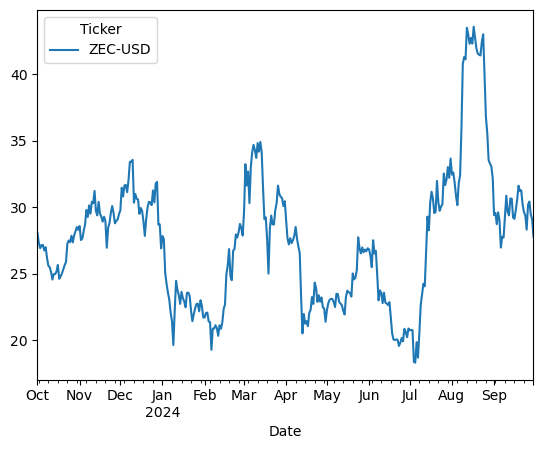

In [30]:
#first visualise data 
df['Close'].plot()
plt.show()

In [31]:
df['Close_smooth'] = df['Close'].rolling(window=3).mean()

# 3. Add day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df.index.dayofweek

# 4. Drop rows with NaN from rolling mean
df = df.dropna()

# 5. Reorder columns (optional but nice)
df = df[['Close_smooth', 'Volume', 'day_of_week']]

In [32]:
df

Price,Close_smooth,Volume,day_of_week
Ticker,,ZEC-USD,
Date,,,
2023-10-03,27.427790,39276194,1
2023-10-04,27.122104,40237126,2
2023-10-05,27.072433,39176880,3
2023-10-06,27.014357,40797786,4
2023-10-07,26.961298,36002104,5
...,...,...,...
2024-09-26,29.298665,73025475,3
2024-09-27,29.644467,67969445,4


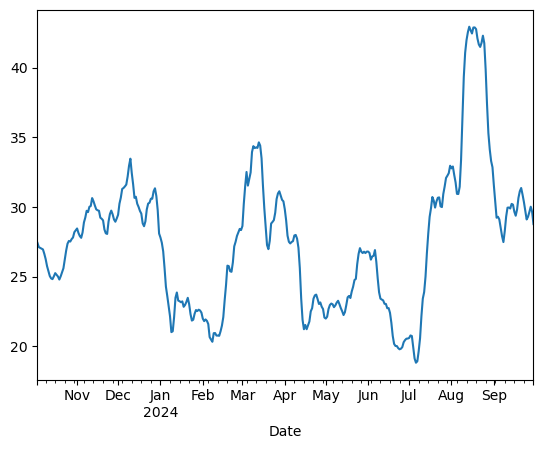

In [33]:
#first visualise data 
df['Close_smooth'].plot()
plt.show()

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_seq2seq_dataset(data, time_step=60, forecast_horizon=20):
    X, y = [], []
    for i in range(len(data) - time_step - forecast_horizon):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step:i + time_step + forecast_horizon, 0])  # Predict only 'Close_smooth'
    return np.array(X), np.array(y)


time_step = 60
forecast_horizon = 20

X, y = create_seq2seq_dataset(scaled_data, time_step, forecast_horizon)
X = X.reshape(X.shape[0], X.shape[1], scaled_data.shape[1])  # (samples, time_steps, features)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [58]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.3))

model.add(Dense(forecast_horizon))  

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 60, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │           1,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,020 (125.08 KB)

 Trainable params: 32,020 (125.08 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0111 - val_loss: 0.0141
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0117 - val_loss: 0.0076
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0112 - val_loss: 0.0145
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0099 - val_loss: 0.0123
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0102 - val_loss: 0.0131
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0099 - val_loss: 0.0187
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0108 - val_loss: 0.0146
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097 - val_loss: 0.0251
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0106 - val_loss: 0.0140
E

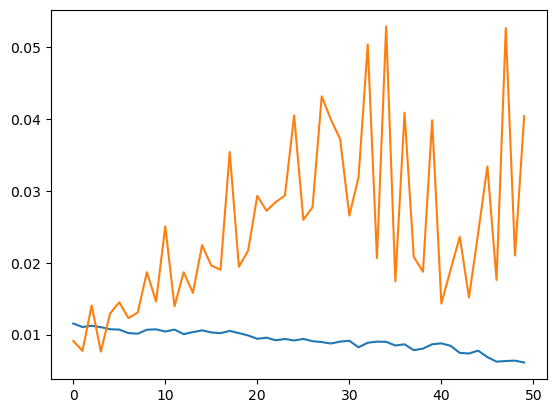

In [61]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [62]:
predicted_seq = model.predict(X_test)  # shape: (samples, 20)

# Pad and inverse transform
def inverse_transform_sequence(seq_pred):
    padded = np.concatenate([seq_pred.reshape(-1, 1), np.zeros((seq_pred.size, 2))], axis=1)
    return scaler.inverse_transform(padded)[:, 0]

# Apply to all predictions
predicted_prices_all = np.array([inverse_transform_sequence(p) for p in predicted_seq])
y_test_rescaled = np.array([inverse_transform_sequence(y) for y in y_test])


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


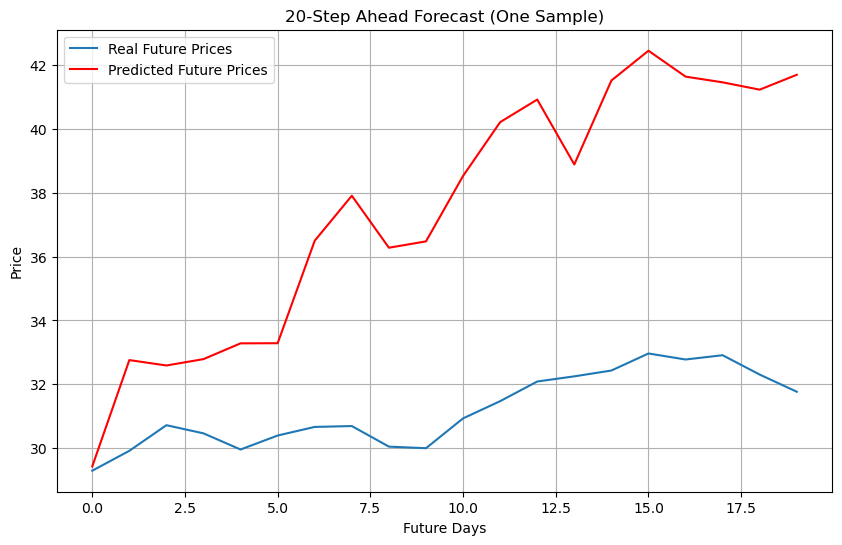

In [64]:
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled[0], label="Real Future Prices")
plt.plot(predicted_prices_all[0], label="Predicted Future Prices", color='red')
plt.title("20-Step Ahead Forecast (One Sample)")
plt.xlabel("Future Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
y_true = y_test_rescaled.flatten()
y_pred = predicted_stock_price.flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 33.7549
Mean Squared Error (MSE): 1168.8657
R² Score: -36.4898


In [55]:
time_step = 60
future_steps = 20

# Start with the last sequence of shape (60, 3)
last_sequence = scaled_data[-time_step:]  # shape: (60, 3)
input_seq = last_sequence.reshape(1, time_step, scaled_data.shape[1])  # (1, 60, 3)

# List to store predictions
future_predictions = []

for _ in range(future_steps):
    # Predict only the 'Close_smooth' (1 value)
    next_pred = model.predict(input_seq, verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # Create dummy values for other features (Volume, Day of Week)
    dummy_volume = 0  # or use the last known scaled value
    dummy_day_of_week = (input_seq[0, -1, 2] + 1) % 7 / 6  # normalize to [0, 1]

    # Form new timestep with predicted close + dummy values
    next_input = np.array([[next_pred[0, 0], dummy_volume, dummy_day_of_week]])
    
    # Append new timestep, remove oldest timestep
    input_seq = np.append(input_seq[:, 1:, :], next_input.reshape(1, 1, 3), axis=1)

# Inverse scale predictions
# Pad with zeros for missing features to match scaler input
padded_predictions = np.concatenate([
    np.array(future_predictions).reshape(-1, 1),
    np.zeros((future_steps, 2))  # for Volume and day_of_week
], axis=1)

# Inverse transform only the Close_smooth
future_predictions_actual = scaler.inverse_transform(padded_predictions)[:, 0]

# Print results
print("Forecast for next 20 days:")
print(future_predictions_actual)


Forecast for next 20 days:
[28.03255729 27.75008891 27.41327545 27.05117994 26.67983602 26.30797835
 25.9404535  25.57998766 25.22813646 24.88580313 24.55351147 24.23157982
 23.92019499 23.61946619 23.32946098 23.05022892 22.7818074  22.52423484
 22.277577   22.04188561]


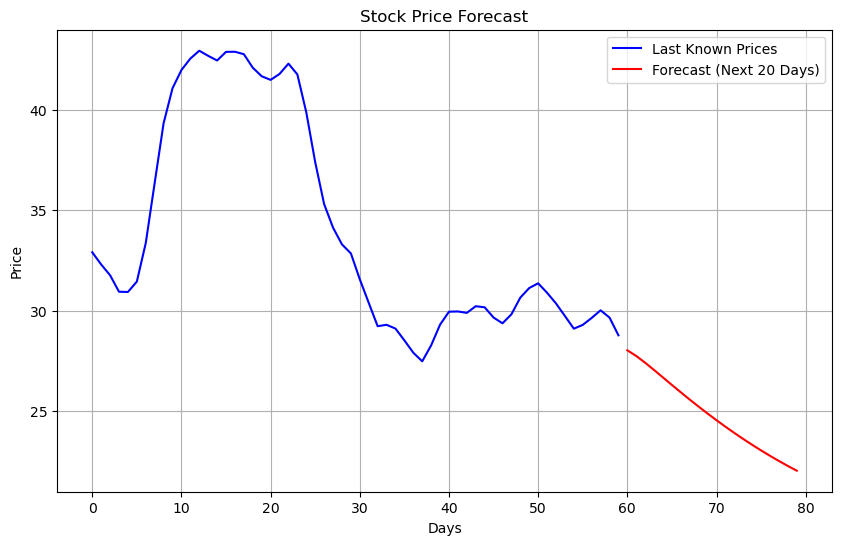

In [56]:
import matplotlib.pyplot as plt

# Prepare the last known real prices (for plotting continuity)
last_known_scaled = scaled_data[-time_step:, 0]  # Only 'Close_smooth' feature
last_known_padded = np.concatenate([
    last_known_scaled.reshape(-1, 1),
    np.zeros((time_step, 2))
], axis=1)

last_known_prices = scaler.inverse_transform(last_known_padded)[:, 0]  # Only the Close values

# Combine last known with future predictions
forecast_plot = np.concatenate((last_known_prices, future_predictions_actual.flatten()))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(last_known_prices)), last_known_prices, label='Last Known Prices', color='blue')
plt.plot(range(len(last_known_prices), len(forecast_plot)), future_predictions_actual, label='Forecast (Next 20 Days)', color='red')
plt.title("Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


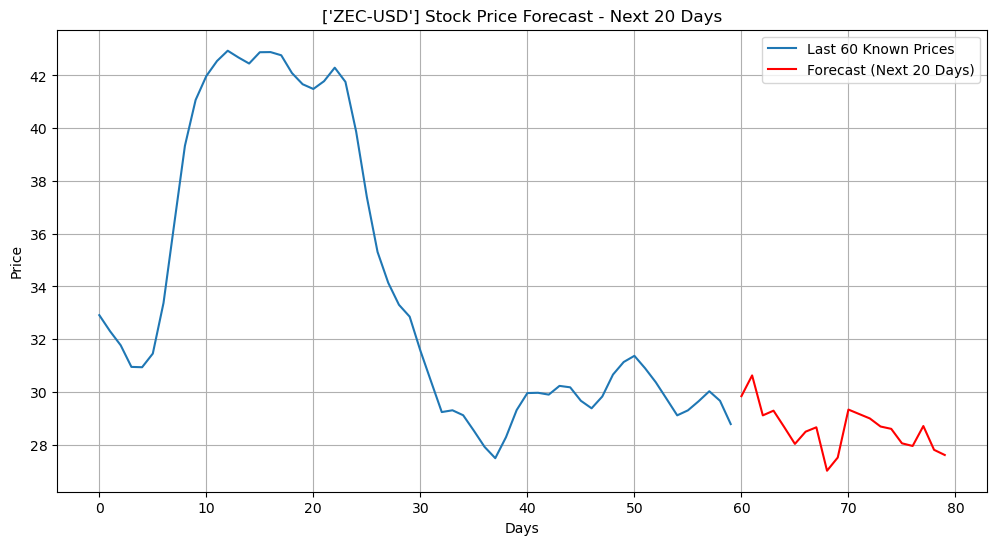

In [65]:
# Get the last 60 timesteps from the entire scaled dataset
last_input_seq = scaled_data[-time_step:]  # shape: (60, 3)
last_input_seq = last_input_seq.reshape(1, time_step, scaled_data.shape[1])  # shape: (1, 60, 3)
future_prediction_scaled = model.predict(last_input_seq)  # shape: (1, 20)
future_prediction_scaled = future_prediction_scaled[0]    # shape: (20,)
# Pad with dummy columns to match scaler's 3-feature input
padded_future_preds = np.concatenate([
    future_prediction_scaled.reshape(-1, 1),  # predicted close_smooth
    np.zeros((forecast_horizon, 2))           # dummy Volume and day_of_week
], axis=1)

# Inverse transform
future_prediction_actual = scaler.inverse_transform(padded_future_preds)[:, 0]
# Get last known real prices for context (unscale them)
last_known_scaled = scaled_data[-time_step:, 0].reshape(-1, 1)  # only Close_smooth
padded_last_known = np.concatenate([last_known_scaled, np.zeros((time_step, 2))], axis=1)
last_known_actual = scaler.inverse_transform(padded_last_known)[:, 0]

# Combine for plotting
full_forecast_plot = np.concatenate((last_known_actual, future_prediction_actual))

plt.figure(figsize=(12, 6))
plt.plot(range(len(last_known_actual)), last_known_actual, label='Last 60 Known Prices')
plt.plot(range(len(last_known_actual), len(full_forecast_plot)), future_prediction_actual, label='Forecast (Next 20 Days)', color='red')
plt.title(f'{tick} Stock Price Forecast - Next 20 Days')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


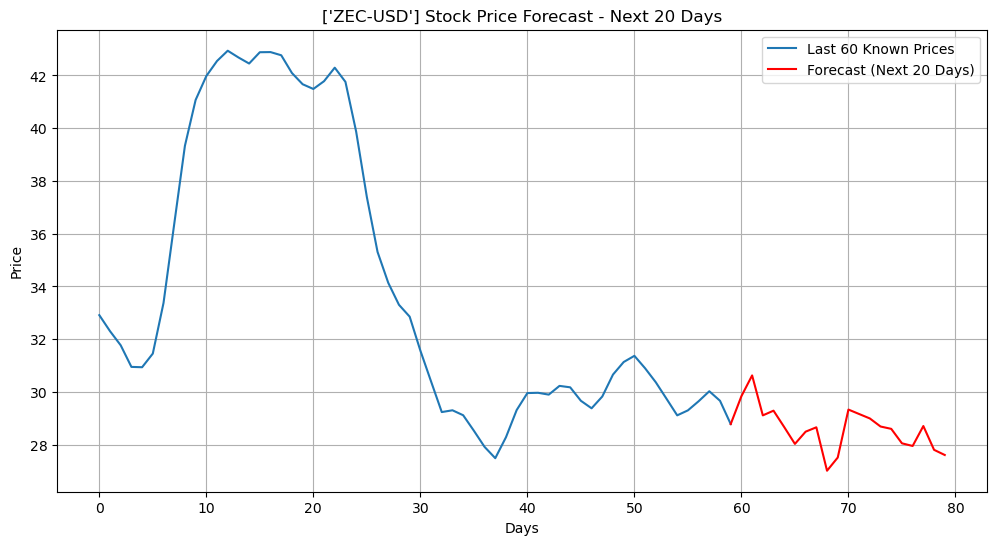

In [66]:
# Add last known actual price to the forecast line
future_prediction_actual_with_anchor = np.concatenate((
    [last_known_actual[-1]],  # anchor point
    future_prediction_actual
))

# Extend the x-axis accordingly
plt.figure(figsize=(12, 6))
plt.plot(range(len(last_known_actual)), last_known_actual, label='Last 60 Known Prices')
plt.plot(range(len(last_known_actual)-1, len(last_known_actual) + forecast_horizon), 
         future_prediction_actual_with_anchor, 
         label='Forecast (Next 20 Days)', color='red')
plt.title(f'{tick} Stock Price Forecast - Next 20 Days')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
